# Reddit NLP Data Cleaning & EDA

## Overview

Financial scams in Singapore have seen increases in the recent years, especially as more and more transactions migrate online. In 2020, cases reported rose <a href= 'https://www.channelnewsasia.com/singapore/more-than-201-million-cheated-top-10-scam-types-2020-police-339081'>65.1% up to 15,756 total cases, from 9,545 cases in the previous year</a>. With cyber crime on the rise and <a href= 'https://www.acfe.com/fraud-examiner.aspx?id=4294997223'>elderly individuals being the most frequent target</a>, there is an onus to try to protect them as much as possible. 

A division of our Government, Classifying Spam Agency of Singapore, wants to work with us to try to develop a filter that specifically targets financial updates. Their issue is two fold:

-  The recent rise in the multitude of online opinions on the best financial investments, such as meme stocks, cryptocurrency
-  The increase in mobile investment apps easing the path to investing, as well as allowing the masses access to such investing tools as options trading and leveraging

This has led to an increase in the more vulnerable classes losing their life savings on uneducated and risky bets.

The goal is to try to create a filter that can help label financial news for this division, CSA:
1. To flag the type of news that comes out, if it involves trendy financial topics
2. To help provide news that is still balanced and conservative to help educate the masses on investments in a gainful manner
3. To prevent the topics of meme stocks, cryptocurrency, and such news from flooding the market and as a consequence, prevent scams related to such topics

We will scrape two large, popular subreddits, r/personalfinance and r/wallstreetbets, with the aim of training a filter to flag posts that are too focused on trending financial news and flag them for review.

## Model Considerations

Due to the nature of the task and the model, we will be trying to reduce the number of type 2 II errors as much as possible. Allowing false positives through, mean that we will have to look over a few more posts/articles to ensure that they are inline with expectations.

However, allowing false negatives through, may unduly influence more of the vulnerable classes into detrimental transactions, which is expressly what we are trying to prevent. Fixing these situations would be much more difficult and much costlier, and may even be impossible.

Hence, for the purposes of this project, we will looks to maximise the Sensitivity over the Specificity.

## Initial Hypothesis

At first glance, these two subreddits are both financially related, and we would expect there to be a fairly comprehensive coverage of financial terms. However, the two do have very different crowds, particularly when considering only the posts that are being made, and not so much the comments.

#### r/personalfinance 
- Posters here to be more beginners seeking financial help
- Topics would tend to include issues more to do with daily life or saving for retirement:
    - Individual Retirement Accounts (IRAs)
    - Debt (House, cars,...)
    - Budgeting
    - Sudden Windfalls
    
#### r/wallstreetbets
- Posters here tend to be people who are more in tune with current financial trends, even if they are not actually financially savvy
- Posts tend to include topics related to stock market investing and feature many meme phrase, and will often be laser focused on the latest trends:
    - Common stock tickers recently include: Gamestop(GME), AMC Theatres(AMC)
    - Common trends in recent history include: Robinhood & investing as an individual, short selling & options trading
    - They will also tend to regard investing with a shorter-term investment window (as opposed to til retirement for r/personal finance)
    
### Stop words
Stopwords will initially include the names of the 2 subreddits, as well as various trending stock tickers and memes in wallstreetbets.

### Contents
- [Import Data](#Import-Data)
- [Functions](#Functions)
- [Data Cleaning & EDA](#Data-Cleaning-&-EDA)
- [Saving Data for Model Testing](#Saving-Data-for-Model-Testing)

### Datsets

* [`reddit.csv`](.reddit.csv): Raw Reddit data scraped and combined
* [`reddit_clean.csv`](.reddit_clean.csv): Cleaned Reddit data for modelling

### Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|**is_wallstreetbets**|*int*|reddit_clean|Whether the post is from wallstreetbets (1 for yes, 0 for no)|
|**word_sum**|*object*|reddit_clean|All the words in the post (Title + selftext)|
|**title**|*object*|reddit_clean|Title of the post|
|**selftext**|*object*|reddit_clean|Body text of the subreddit post|
|**words_clean**|*object*|reddit_clean|Tokenized words from the whole post in a single string|
|**words_lem**|*object*|reddit_clean|Lemmatized words from the whole post in a single string|
|**words_stem**|*object*|reddit_clean|Stemmed words from the whole post in a single string|
|**word_count**|*int*|reddit_clean|Number of words in the title and selftext|

## Import Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
# from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
     
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer


plt.style.use('bmh')
%matplotlib inline  

In [2]:
reddit = pd.read_csv('datasets/reddit.csv').drop(columns = ['Unnamed: 0', 'retrieved_on'])

## Functions

In [3]:

def tokenize_str(words, lemm = False, stem = False):
    '''This function tokenizes a string, removes any urls beginning with http, and then recombines
    them into 1 string'''
    lemmatizer = WordNetLemmatizer()     # Instantiate Lemmatizer
    p_stemmer = PorterStemmer()          # Instantiate PorterStemmer
    words_interm = re.sub(
        r'https:\/\/preview.redd.it\/\w+.png\?width=\d+(\s+\w+=\w+)+',
        '', words)
    clean_words = re.sub(
        r'https?:\/\/(?:www2?\.|(?!www2?))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}',
        '', words_interm)
    word_tokens = tokenizer.tokenize(clean_words)
    
    if lemm == True:                     # Lemmatise if true
        word_tokens = [lemmatizer.lemmatize(word) for word in word_tokens]
        
    # Check for stop words here
    
    if stem == True:                     # Stem if true
        word_tokens = [p_stemmer.stem(word) for word in word_tokens]
        
    return ' '.join(word_tokens)
        

def words_of_interest(vec, initial_word_list, suptitle, list_of_titles, fig_size):
    '''function takes an instantiated feature extractor (countvectorizer) and:
    1. creates a dataseries of words 
    2. returns the 25 most common and least common words in the dataseries
    3. plots a bar plot of the 15 most and least commong words'''
    converted_word_list = vec.fit_transform(initial_word_list)                        # Transforms dataseries
    sum_words = converted_word_list.sum(axis=0)                                       # Sum along the column
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()] # List of tuples (word, freq)    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)               # Sorts list in descending order
    word_pd = pd.DataFrame(
        columns = ['word', 'frequency'],
        data = words_freq
    )
    print(f'The top 25 most common terms are: \n{words_freq[:25]}',
          '\n---------------\n\n',
          f'The top 25 least common terms are: \n{words_freq[:-25:-1]}',
         '\n---------------\n')
    
    fig, axs = plt.subplots(1, 2, figsize = fig_size)
    fig.suptitle(suptitle, fontsize = 18)
    fig.tight_layout(pad = 0, w_pad = 8.0, h_pad = 1.0 , rect = [0, 0, 1, 0.95]) 
    
    axs[0].set_title(list_of_titles[0], fontsize = 12)
    sns.barplot(
        ax = axs[0],
        y = 'word',
        x = 'frequency',
        palette = 'dark:blue',
        data = word_pd.head(15)
    )
    
    axs[1].set_title(list_of_titles[1], fontsize = 12)
    sns.barplot(
        ax = axs[1],
        y = 'word',
        x = 'frequency',
        palette = 'light:blue',
        data = word_pd.tail(15)
    )

In [4]:
# Including various subreddit related terms in the stopwords

stop_words = frozenset(['personalfinance', 'personal', 'finance', 'wallstreetbets', 'bets', 'wallstreet', 'wsb',
                        'wall street', 'gme', 'gamestop', 'game stop', 'amc', 'amc entertainment', 'tmc', 'ast',
                        'robinhood'])

english_stop_words = ENGLISH_STOP_WORDS.union(stop_words)

## Data Cleaning & EDA

In [5]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8580 entries, 0 to 8579
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  8580 non-null   object
 1   title      8580 non-null   object
 2   selftext   5622 non-null   object
dtypes: object(3)
memory usage: 201.2+ KB


In [6]:
reddit.isna().sum()

subreddit       0
title           0
selftext     2958
dtype: int64

In [7]:
# Changing data to lowercase
for col in reddit.columns:
    reddit[col] = reddit[col].str.lower()

In [8]:
# Checking for removed posts
reddit.loc[(reddit['title'] == '[removed]') |
           (reddit['selftext'] == '[removed]'),
:].groupby('subreddit').agg('count')

,title,selftext
subreddit,,
personalfinance,545,545
wallstreetbets,1278,1278


In [9]:
# Checking to see if titles are removed in removed posts
reddit.loc[reddit['title'] == '[removed]',:]

,subreddit,title,selftext


In [10]:
reddit[reddit['selftext'].isna()].groupby('subreddit').count()

,title,selftext
subreddit,,
personalfinance,11,0
wallstreetbets,2947,0


In [11]:
for col in reddit.columns:
    reddit[col] = reddit[col].replace('[removed]', np.nan)

In [12]:
reddit.loc[(reddit['title'].isna()) |
           (reddit['selftext'].isna()),
:].groupby('subreddit').agg('count') 

,title,selftext
subreddit,,
personalfinance,556,0
wallstreetbets,4225,0


In [13]:
reddit.dropna(inplace = True)

In [14]:
reddit = pd.concat(
    objs = [
        # Randomly sample 1500 posts from personal finance to even out the classes
        reddit[reddit['subreddit'] == 'personalfinance'].sample(1500, replace = False, random_state = 42),
        reddit[reddit['subreddit'] == 'wallstreetbets']
    ],
    axis = 0
).reset_index(drop = True)

In [15]:
reddit.groupby('subreddit').agg('count')

,title,selftext
subreddit,,
personalfinance,1500,1500
wallstreetbets,1338,1338


### Removed Posts

When posts are removed from Reddit, the selftext describing the posts is removed as well but it looks like often, the titles are left intact. However, as I have scraped enough posts to be able to still have enough data in my dataset with the removed posts dropped, I will the \[removed\] from the dataset and drop all the rows, alongside any empty rows.

In [16]:
print("The number of posts with duplicated titles are:",
      f"\n{reddit.duplicated(subset = 'title').value_counts()}",
      "\n--------",
      f"\n\nThe number of posts with duplicated selftexts are:",
      f"\n{reddit.duplicated(subset = 'selftext').value_counts()}")

The number of posts with duplicated titles are: 
False    2821
True       17
dtype: int64 
-------- 

The number of posts with duplicated selftexts are: 
False    2805
True       33
dtype: int64


In [17]:
reddit.drop_duplicates(subset = 'title', keep='first', inplace=True)         # Drop Duplicate Titles
reddit.drop_duplicates(subset = 'selftext', keep='first', inplace=True)      # Drop Duplicate Selftext

In [18]:
reddit.loc[
    (reddit['subreddit'] == 'wallstreetbets') &
    (reddit['selftext'].notna())
    , :]

,subreddit,title,selftext
1500,wallstreetbets,the market won’t crash,market prices are based on demand and offer. \...
1501,wallstreetbets,$yang gang update - we’re fuk (maybe) - part 3,yeahh.... sooo xinnie the pooh just [took over...
1502,wallstreetbets,stockjesus interesting trades,here are the trades that you need to be watchi...
1503,wallstreetbets,entain plc rejects bid from draftkings,2:03a et 9/22/2021 - dow jones\n*entain plc re...
1504,wallstreetbets,[theorical case] what would happen in we boost...,"as you know, the possible bankruptcy of evergr..."
...,...,...,...
2833,wallstreetbets,i made a mistake about $irnt.,i posted before why i thought $irnt was going ...
2834,wallstreetbets,irnt short squeeze!,"sorry i am late to report, but at least i'm re..."
2835,wallstreetbets,spy options - suggestions 3,this is my third post. past two times when spy...
2836,wallstreetbets,indp is just getting started,indp had a great run today and made good money...


In [19]:
reddit['is_wallstreetbets'] = reddit['subreddit'].map(lambda x: 1 if x == 'wallstreetbets' else 0)

### Binarising the Dependent Variable

A new column 'is_personalfinance' was created to binarise the dependent variable for modelling:

1 - if the row is from wallstreetbets

0 - if the row is from personalfinance

In [20]:
reddit['word_sum'] = reddit['title'] + ' ' + reddit['selftext']

In [21]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2789 entries, 0 to 2837
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subreddit          2789 non-null   object
 1   title              2789 non-null   object
 2   selftext           2789 non-null   object
 3   is_wallstreetbets  2789 non-null   int64 
 4   word_sum           2789 non-null   object
dtypes: int64(1), object(4)
memory usage: 130.7+ KB


### Collating Data

The title and selftext columns were collated to gather all the data into a new column.

In [22]:
# New DataFrame for Vectorisation and Naive Bayes Modelling
reddit_clean = reddit[['is_wallstreetbets', 'word_sum', 'title', 'selftext']]

In [23]:
reddit_clean['word_sum'] = reddit_clean['word_sum'].map(
    lambda x: x.replace(
        '\n', ' '
    ).replace(
        '&amp;', ' '
    ).replace(
        '#x',''
    )
)

<ipython-input-23-7321203df164>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reddit_clean['word_sum'] = reddit_clean['word_sum'].map(


In [24]:
# Checking base probabilities
reddit_clean['is_wallstreetbets'].value_counts(normalize = True)

0    0.536034
1    0.463966
Name: is_wallstreetbets, dtype: float64

### Tokenizing Data

In [25]:
# Tokenizer user with a regexp to pull either a group of chars or a sum of money beginnig with 
# a $, digits, and then possibly a letter, for example - $40k
tokenizer = RegexpTokenizer('[a-zA-Z]+')                  # group of chars

In [26]:
# Columns for tokenized words
reddit_clean['words_clean'] = reddit_clean['word_sum'].apply(tokenize_str)

# Column for lemmatized words
reddit_clean['words_lem'] = reddit_clean['word_sum'].apply(lambda x: tokenize_str(x, lemm = True))

# Column for stemmed words
reddit_clean['words_stem'] = reddit_clean['word_sum'].apply(lambda x: tokenize_str(x, stem = True))

### Most Common and Least Common Words

In [27]:
wallstreetbets = reddit_clean.loc[(reddit_clean['is_wallstreetbets'] == 1),
                                                         ['words_clean']]

personalfinance = reddit_clean.loc[(reddit_clean['is_wallstreetbets'] == 0),
                                                         ['words_clean']]

In [28]:
cvec_init = CountVectorizer()

The top 25 most common terms are: 
[('to', 8128), ('the', 7701), ('and', 6149), ('my', 5121), ('in', 3844), ('for', 3539), ('of', 3472), ('is', 3115), ('it', 3032), ('have', 2702), ('that', 2649), ('this', 1994), ('on', 1981), ('with', 1870), ('but', 1757), ('be', 1678), ('or', 1345), ('me', 1293), ('so', 1252), ('not', 1249), ('we', 1242), ('if', 1240), ('at', 1213), ('would', 1201), ('as', 1197)] 
---------------

 The top 25 least common terms are: 
[('shooting', 1), ('presumptuous', 1), ('phoenix', 1), ('flaw', 1), ('dfw', 1), ('surrounding', 1), ('negativity', 1), ('twenties', 1), ('deactivate', 1), ('turbulence', 1), ('purposefully', 1), ('debacle', 1), ('yours', 1), ('sloppy', 1), ('boarding', 1), ('recruiting', 1), ('rehire', 1), ('restricting', 1), ('alarms', 1), ('indifference', 1), ('reflects', 1), ('duty', 1), ('ceasing', 1), ('continent', 1)] 
---------------



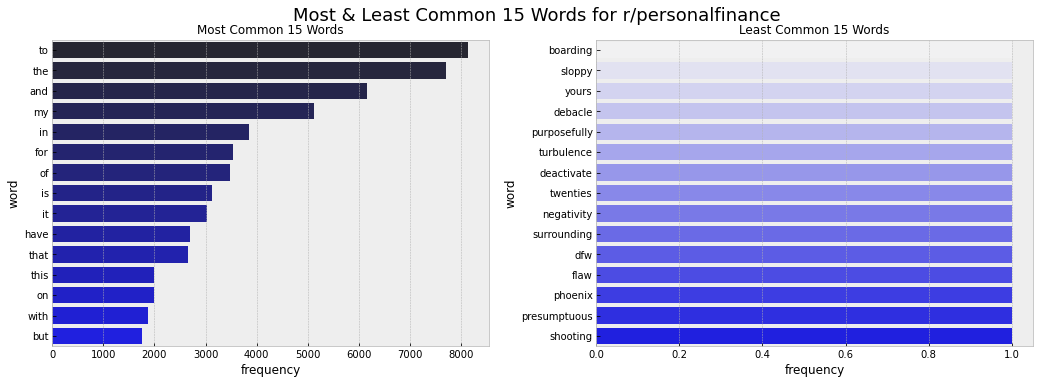

In [29]:
titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_init, 
    personalfinance['words_clean'],
    'Most & Least Common 15 Words for r/personalfinance', 
    titles, 
    (14,5)
);

The top 25 most common terms are: 
[('the', 11265), ('to', 7021), ('and', 6007), ('of', 5095), ('is', 4371), ('in', 3777), ('this', 2853), ('for', 2734), ('it', 2710), ('that', 2520), ('on', 2373), ('you', 1905), ('with', 1710), ('are', 1696), ('at', 1577), ('be', 1448), ('as', 1444), ('have', 1362), ('they', 1256), ('will', 1195), ('but', 1147), ('if', 1103), ('not', 1080), ('we', 1073), ('from', 1042)] 
---------------

 The top 25 least common terms are: 
[('lighten', 1), ('fantasy', 1), ('combine', 1), ('incorporate', 1), ('nod', 1), ('hearted', 1), ('disrespectful', 1), ('passions', 1), ('cures', 1), ('bloomers', 1), ('misunderstood', 1), ('liquor', 1), ('nightclubs', 1), ('unaudited', 1), ('twelve', 1), ('forgiven', 1), ('lounges', 1), ('coronavirus', 1), ('pest', 1), ('cable', 1), ('modified', 1), ('deferral', 1), ('salaried', 1), ('enacted', 1)] 
---------------



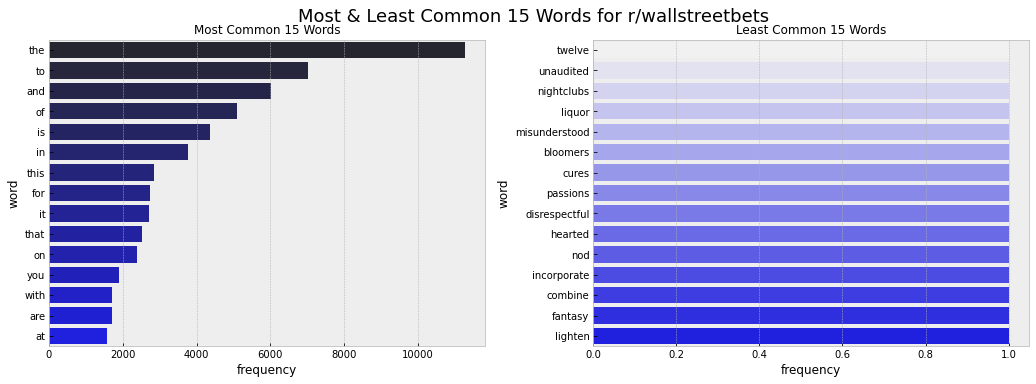

In [30]:
cvec_init = CountVectorizer()

titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_init, 
    wallstreetbets['words_clean'],
    'Most & Least Common 15 Words for r/wallstreetbets', 
    titles, 
    (14,5)
);

C:\Users\Ming\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['entertainment', 'game', 'stop', 'street', 'wall'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


The top 25 most common terms are: 
[('just', 991), ('credit', 917), ('pay', 911), ('money', 861), ('year', 811), ('car', 795), ('account', 783), ('like', 726), ('years', 675), ('time', 668), ('don', 658), ('loan', 613), ('new', 608), ('house', 575), ('want', 561), ('month', 556), ('ve', 551), ('know', 548), ('job', 519), ('card', 492), ('need', 486), ('debt', 486), ('home', 471), ('make', 466), ('tax', 438)] 
---------------

 The top 25 least common terms are: 
[('stigma', 2), ('itunes', 2), ('conditionally', 2), ('fskax', 2), ('morale', 2), ('parnassus', 2), ('intl', 2), ('vviax', 2), ('voe', 2), ('gtsvx', 2), ('fspsx', 2), ('jibcx', 2), ('goods', 2), ('logging', 2), ('rejections', 2), ('venture', 2), ('memo', 2), ('rav', 2), ('cherokee', 2), ('ascensus', 2), ('france', 2), ('sdc', 2), ('smile', 2), ('argued', 2)] 
---------------



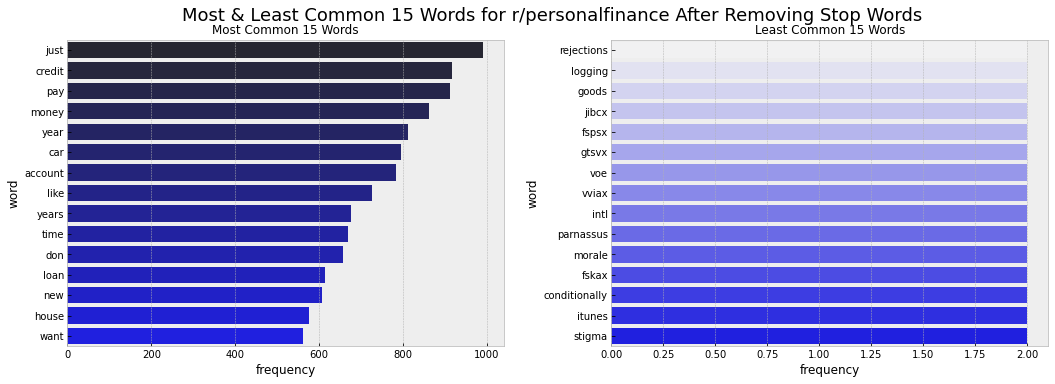

In [31]:
cvec_init_stop_words = CountVectorizer(
    max_features = 5000,     # Cutting off the features to speed up the process and remove unique words
    stop_words = english_stop_words   # Changing countvectorizer parameters to include english stop words
)

titles =['Most Common 15 Words', 'Least Common 15 Words']

words_of_interest(
    cvec_init_stop_words, 
    personalfinance['words_clean'],
    'Most & Least Common 15 Words for r/personalfinance After Removing Stop Words', 
    titles, 
    (14,5)
);

The top 25 most common terms are: 
[('shares', 961), ('market', 928), ('stock', 924), ('price', 793), ('like', 702), ('company', 697), ('short', 667), ('just', 653), ('buy', 548), ('money', 481), ('time', 479), ('float', 479), ('going', 436), ('squeeze', 417), ('know', 410), ('million', 392), ('year', 380), ('think', 366), ('high', 366), ('options', 360), ('week', 360), ('don', 355), ('today', 343), ('share', 343), ('good', 327)] 
---------------

 The top 25 least common terms are: 
[('wingspan', 3), ('amidst', 3), ('tost', 3), ('chef', 3), ('tattooed', 3), ('intriguing', 3), ('vmware', 3), ('tigr', 3), ('affiliates', 3), ('workout', 3), ('jun', 3), ('algo', 3), ('keith', 3), ('angle', 3), ('kenny', 3), ('longest', 3), ('identified', 3), ('manifesting', 3), ('vivid', 3), ('loophole', 3), ('idiot', 3), ('ammo', 3), ('theo', 3), ('alsn', 3)] 
---------------



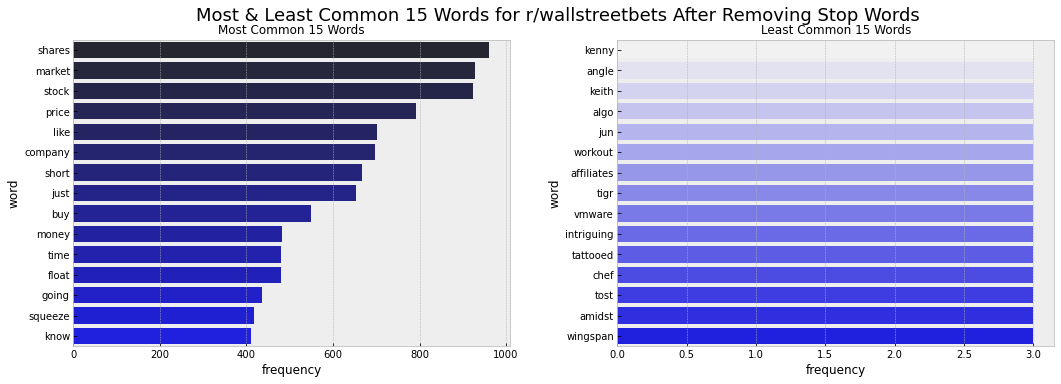

In [32]:
words_of_interest(
    cvec_init_stop_words, 
    wallstreetbets['words_clean'],
    'Most & Least Common 15 Words for r/wallstreetbets After Removing Stop Words', 
    titles, 
    (14,5)
);

#### English Stop Words

In an examination of the the most common words within each set, removing English stop words, names of the subreddits, and some commonly used slang, we can see that we develop a large differentiation between the top 15 most common words for both subreddits.

### Post Length

In [33]:
reddit_clean['word_count'] = reddit_clean['words_clean'].map(lambda x: len(x.split(' ')))
reddit_clean.groupby('is_wallstreetbets')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
is_wallstreetbets,,,,,,,,
0,1495.0,169.302341,142.173375,5.0,82.0,131.0,216.0,2035.0
1,1294.0,201.940495,378.181099,2.0,44.0,84.0,191.0,5626.0


In [34]:
reddit_clean.loc[(reddit_clean['word_count'] > 2000), ['is_wallstreetbets', 'word_sum']]

,is_wallstreetbets,word_sum
1237,0,capital gains taxes - how to minimize them (an...
1671,1,the rise of canoo ($goev) – why jpow’s printer...
1894,1,"lidr: juicy despac set up with low float, high..."
1934,1,vlta - repost • market cap is $2b no ban pls ...
1971,1,"$clov the ""dude diligence"" dd report 9/19 edit..."
2005,1,tmc- set for explosive week! $tmc - why this c...
2127,1,$tmc - why this company is more than it seems ...
2207,1,wall street week ahead for the trading week be...
2354,1,vlta - bla bla de-spac blabla gamma ramp bla b...
2371,1,gme is about to fuk u with its negative beta. ...


With an upper quantile of 207 characters, we will look at the majority of posts in this range (0-250 words) to examine the distribution of post length.

In checking outliers longer than or about as long as the longest personalfinance reddit post, we will also drop row 2709, which is a duplicate post that snuck through due to spelling errors.

In [35]:
reddit_clean.drop(2709, inplace = True)

In [36]:
reddit_clean.reset_index(drop = True, inplace = True)

In [37]:
reddit_word_length = reddit_clean.loc[(reddit_clean['word_count'] < 250), ['is_wallstreetbets', 'word_count']]

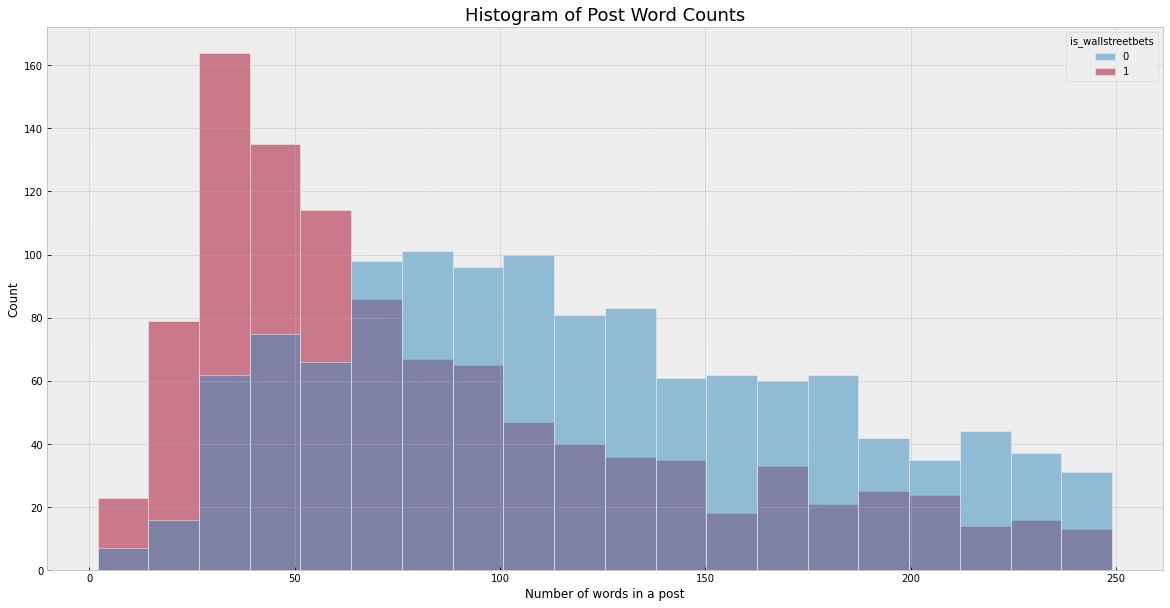

In [38]:
plt.figure(figsize = (20,10))
plt.title('Histogram of Post Word Counts', fontsize = 18)
plt.xlabel('Number of words in a post')
sns.histplot(
    x = 'word_count',
    hue = 'is_wallstreetbets',
    data = reddit_word_length,
    bins = 20
    );

#### Analysis of Post Length

In general, r/personalfinance tends to see longer posts, however, we do see a number of extreme outliers for r/wallstreetbets for post length.

As r/personalfinance is much more of an advisory subreddit, with people explaining their circumstances in the posts and asking for advice, we would tend to see longer posts. On the other hand, r/wallstreetbets can be filled with memes, the latest news, which will require little explanation, and pure speculation.

However, from time to time, r/wallstreetbets does see lengthy breakdowns of current global financial situations, or detailed analysis of specific stocks, resulting in these extreme outliers with post lengths over 1000 words.

## Saving Data for Model Testing

In [39]:
reddit_clean.to_csv('datasets/reddit_clean.csv')

In [40]:
reddit_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2788 entries, 0 to 2787
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   is_wallstreetbets  2788 non-null   int64 
 1   word_sum           2788 non-null   object
 2   title              2788 non-null   object
 3   selftext           2788 non-null   object
 4   words_clean        2788 non-null   object
 5   words_lem          2788 non-null   object
 6   words_stem         2788 non-null   object
 7   word_count         2788 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 174.4+ KB
